In [58]:
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
from funciones_recommendation_system import get_datasets, match_researcher_call, recommendation_system_researcher_call, match_call_researcher, recommendation_system_call_researcher
from funciones_score_computation import get_score_similarity, get_score_position, get_score_cluster

In [59]:
# load databases
path = '/export/data_ml4ds/AI4U/Datasets/'
version_wp = '20240510'
version_rp = '20240321'

df_publications, df_projects, df_publications_researchers,df_projects_researchers, df_researchers, df_calls = get_datasets(path, version_wp, version_rp)

# load the validation set
df_val = pd.read_excel('/export/usuarios_ml4ds/mafuello/Github/recommendation_system_validation/validation_set.xlsx')
df_val['id_researcher'] = df_val['id_researcher'].astype(str)

In [61]:
def contar_repeticiones(lista):
    diccionario = {}
    for numero in lista:
        if numero in diccionario:
            diccionario[numero] += 1
        else:
            diccionario[numero] = 1
    
    return {k: v for k, v in sorted(diccionario.items(), key=lambda item: item[0])}

In [65]:
methods = ['BERT', 'bhattacharyya', 'separated', 'semiseparated']
agg_methods = ['sum', 'mean', 'mean_imp'] 

method = methods[0]
#agg_method = agg_methods[0]

dict_results_researchers = {}
dict_results_calls = {}
scores_researchers = []
scores_calls = []

for agg_method in agg_methods:
    positions_researchers, positions_calls, scores_similarity_researchers, scores_similarity_calls, scores_position_researchers, scores_position_calls, scores_department_researchers,  scores_cluster_calls = [], [], [], [], [], [], [], []
    errores = []
    for i in df_val.index:
        try:
            invID = df_val['id_researcher'][i]
            call = df_val['Línea prioritia/panel/topic'][i]   

            ranking_researchers = recommendation_system_call_researcher(method=method, agg_method=agg_method, call=call, researchers=df_researchers)
            ranking_calls = recommendation_system_researcher_call(method=method, agg_method=agg_method, researcher=invID, calls=df_calls)

            # score similarity
            scores_similarity_researchers.append(get_score_similarity(ranking_researchers, invID, call))
            scores_similarity_calls.append(get_score_similarity(ranking_calls, invID, call))

            # score position
            scores_position_researchers.append(get_score_position(ranking_researchers, invID, call))
            scores_position_calls.append(get_score_position(ranking_calls, invID, call))

            # score department/cluster
            scores_department_researchers.append(get_score_cluster(ranking_researchers, invID, call))
            scores_cluster_calls.append(get_score_cluster(ranking_calls, invID, call))

            # get position
            indice_valor_exacto = ranking_researchers.loc[ranking_researchers['id_researcher'] == invID].index[0]
            ranking_aux = ranking_researchers.iloc[:indice_valor_exacto + 1]
            positions_researchers.append(ranking_aux.shape[0])

            indice_valor_exacto = ranking_calls.loc[ranking_calls['Call'] == call].index[0]
            ranking_aux = ranking_calls.iloc[:indice_valor_exacto + 1]
            positions_calls.append(ranking_aux.shape[0])

        except:
            errores.append(i)
        
    scores_researchers.append([np.mean(scores_similarity_researchers), np.mean(scores_position_researchers), np.mean(scores_department_researchers)])
    scores_calls.append([np.mean(scores_similarity_calls), np.mean(scores_position_calls), np.mean(scores_cluster_calls)])

    dict_results_researchers['{}_{}'.format(method, agg_method)] = contar_repeticiones(positions_researchers)
    dict_results_calls['{}_{}'.format(method, agg_method)] = contar_repeticiones(positions_calls)

        

In [66]:
researchers_sum = dict_results_researchers['{}_sum'.format(method)]
researchers_mean = dict_results_researchers['{}_mean'.format(method)]
researchers_mean_imp = dict_results_researchers['{}_mean_imp'.format(method)]

calls_sum = dict_results_calls['{}_sum'.format(method)]
calls_mean = dict_results_calls['{}_mean'.format(method)]
calls_mean_imp = dict_results_calls['{}_mean_imp'.format(method)]

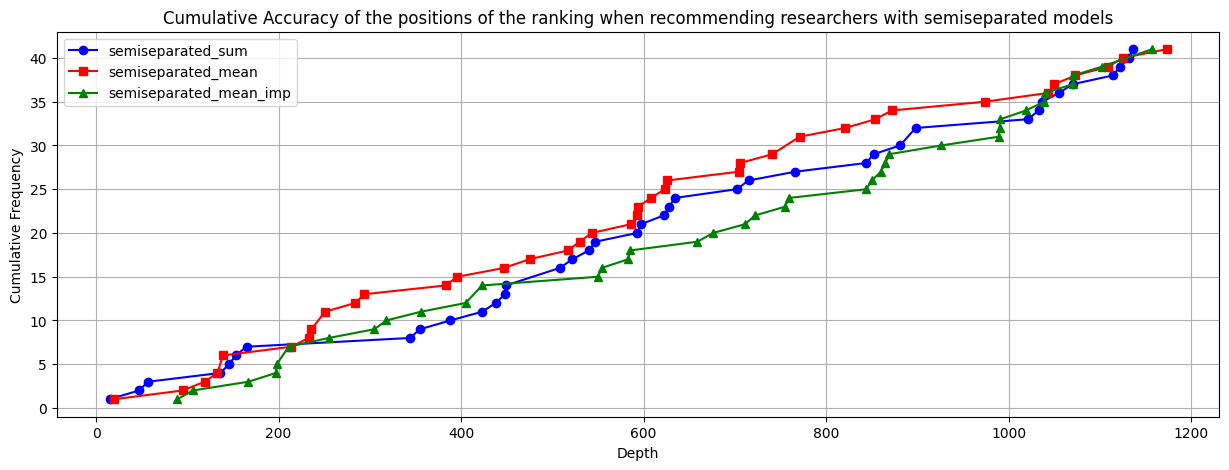

In [81]:
## RESEARCHERS
keys_sum, values_sum = list(researchers_sum.keys()), list(researchers_sum.values())
keys_mean, values_mean = list(researchers_mean.keys()), list(researchers_mean.values())
keys_mean_imp, values_mean_imp = list(researchers_mean_imp.keys()), list(researchers_mean_imp.values())

cumulative_sum = np.cumsum(values_sum)
cumulative_mean = np.cumsum(values_mean)
cumulative_mean_imp = np.cumsum(values_mean_imp)

plt.figure(figsize=(15, 5))
plt.plot(keys_sum, cumulative_sum, marker='o', color='blue', label='{}_sum'.format(method))
plt.plot(keys_mean, cumulative_mean, marker='s', color='red', label='{}_mean'.format(method))
plt.plot(keys_mean_imp, cumulative_mean_imp, marker='^', color='green', label='{}_mean_imp'.format(method))

plt.xlabel('Depth')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Accuracy of the positions of the ranking when recommending researchers with {} models'.format(method))

plt.legend()
plt.grid(True)
plt.show()

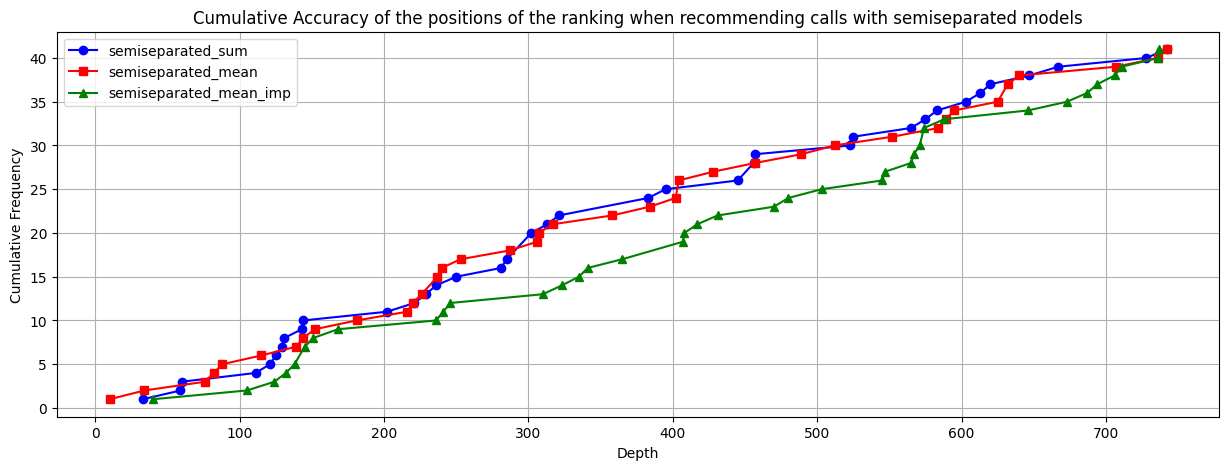

In [82]:
## CALLS

keys_sum, values_sum = list(calls_sum.keys()), list(calls_sum.values())
keys_mean, values_mean= list(calls_mean.keys()), list(calls_mean.values())
keys_mean_imp, values_mean_imp = list(calls_mean_imp.keys()), list(calls_mean_imp.values())

cumulative_sum = np.cumsum(values_sum)
cumulative_mean = np.cumsum(values_mean)
cumulative_mean_imp = np.cumsum(values_mean_imp)

plt.figure(figsize=(15, 5))
plt.plot(keys_sum, cumulative_sum, marker='o', color='blue', label='{}_sum'.format(method))
plt.plot(keys_mean, cumulative_mean, marker='s', color='red', label='{}_mean'.format(method))
plt.plot(keys_mean_imp, cumulative_mean_imp, marker='^', color='green', label='{}_mean_imp'.format(method))

plt.xlabel('Depth')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Accuracy of the positions of the ranking when recommending calls with {} models'.format(method))

plt.legend()
plt.grid(True)
plt.show()

In [70]:
results_researchers = pd.DataFrame(index=['sum', 'mean', 'mean_imp'], columns=['score_similarity', 'score_position', 'score_department'], data=scores_researchers)

In [43]:
results_researchers

,score_similarity,score_position,score_department
sum,0.045574,0.004370,0.047883
mean,0.228318,0.003752,0.047534
mean_imp,0.352477,0.002241,0.045414


In [44]:
results_calls = pd.DataFrame(index=['sum', 'mean', 'mean_imp'], columns=['score_similarity', 'score_position', 'score_cluster'], data=scores_calls)

In [45]:
results_calls

,score_similarity,score_position,score_cluster
sum,0.222489,0.004468,0.150413
mean,0.282351,0.006479,0.149121
mean_imp,0.381947,0.003441,0.132466
